# Word vectors

In [0]:
##imports
import numpy as np
import pandas as pd
import gensim
from bs4 import BeautifulSoup
import re
import nltk

In [0]:
##getting data from https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/kernels?sortBy=voteCount&group=everyone&pageSize=20&datasetId=134715
data_imdb = pd.read_csv(r'/content/drive/My Drive/IMDB Dataset.csv')

In [4]:
#info
data_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [0]:
def clean_text(text):
    '''Cleans the text data'''
    ##remove html tags
    text = BeautifulSoup(text, "html.parser").get_text()
    return text.lower()

In [0]:
data_imdb['review'] = data_imdb['review'].apply(clean_text)

In [7]:
data_imdb.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. the filming tec...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive


We will get the reviews text and train the word2vec using gensim and tensorflow. 

In [0]:
##getting sentence wise data
list_sents = [nltk.word_tokenize(sent) for sent_tok in data_imdb.review for sent in nltk.sent_tokenize(sent_tok)]

In [8]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Tensorflow model ( Skip Gram, Negative Sampling)

1. Get the skipgram data points with negative samples -- tf.keras.preprocessing.sequence.skipgrams
2. Create the model
3. train the model

In [0]:
##tensorflow imports
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, Input, Dot, Reshape
from tensorflow.keras.models import Model
import random as rn

In [0]:
##to use tf.keras.preprocessing.sequence.skipgrams, we have to encode our sentence to numbers. so used Tokenizer class
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(list_sents)
seq_texts = tokenizer.texts_to_sequences(list_sents) ##list of list+

In [0]:
##fixing numpy RS
np.random.seed(42)

##fixing tensorflow RS
tf.random.set_seed(32)

##python RS
rn.seed(12)

tf.keras.backend.clear_session()

##model
def getSGNS():
    
    center_word_input= Input(shape=(1,), name="center_word_input")
    context_word_input= Input(shape=(1,), name="context_word_input")
    
    ##i am initilizing randomly. But you can use predefined embeddings. 
    embedd_layer = Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100,
                    embeddings_initializer=tf.keras.initializers.RandomUniform(seed=45),
                     name="Embedding_layer")
    
    center_wv = embedd_layer(center_word_input)
    
    context_wv = embedd_layer(context_word_input)
    
    dot_out = Dot(axes=2, name="dot_between_center_context")([center_wv, context_wv]) 
    
    dot_out = Reshape((1,), name="reshaping")(dot_out)
    
    final_out = Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.glorot_uniform(seed=54),
                  name="output_layer")(dot_out)
    
    basic_w2v = Model(inputs=[center_word_input, context_word_input], outputs=final_out, name="sgns_w2v")
    
    return basic_w2v


sgns_w2v = getSGNS()

In [13]:
sgns_w2v.summary()

Model: "sgns_w2v"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
center_word_input (InputLayer)  [(None, 1)]          0                                            
__________________________________________________________________________________________________
context_word_input (InputLayer) [(None, 1)]          0                                            
__________________________________________________________________________________________________
Embedding_layer (Embedding)     (None, 1, 100)       20670600    center_word_input[0][0]          
                                                                 context_word_input[0][0]         
__________________________________________________________________________________________________
dot_between_center_context (Dot (None, 1, 1)         0           Embedding_layer[0][0]     

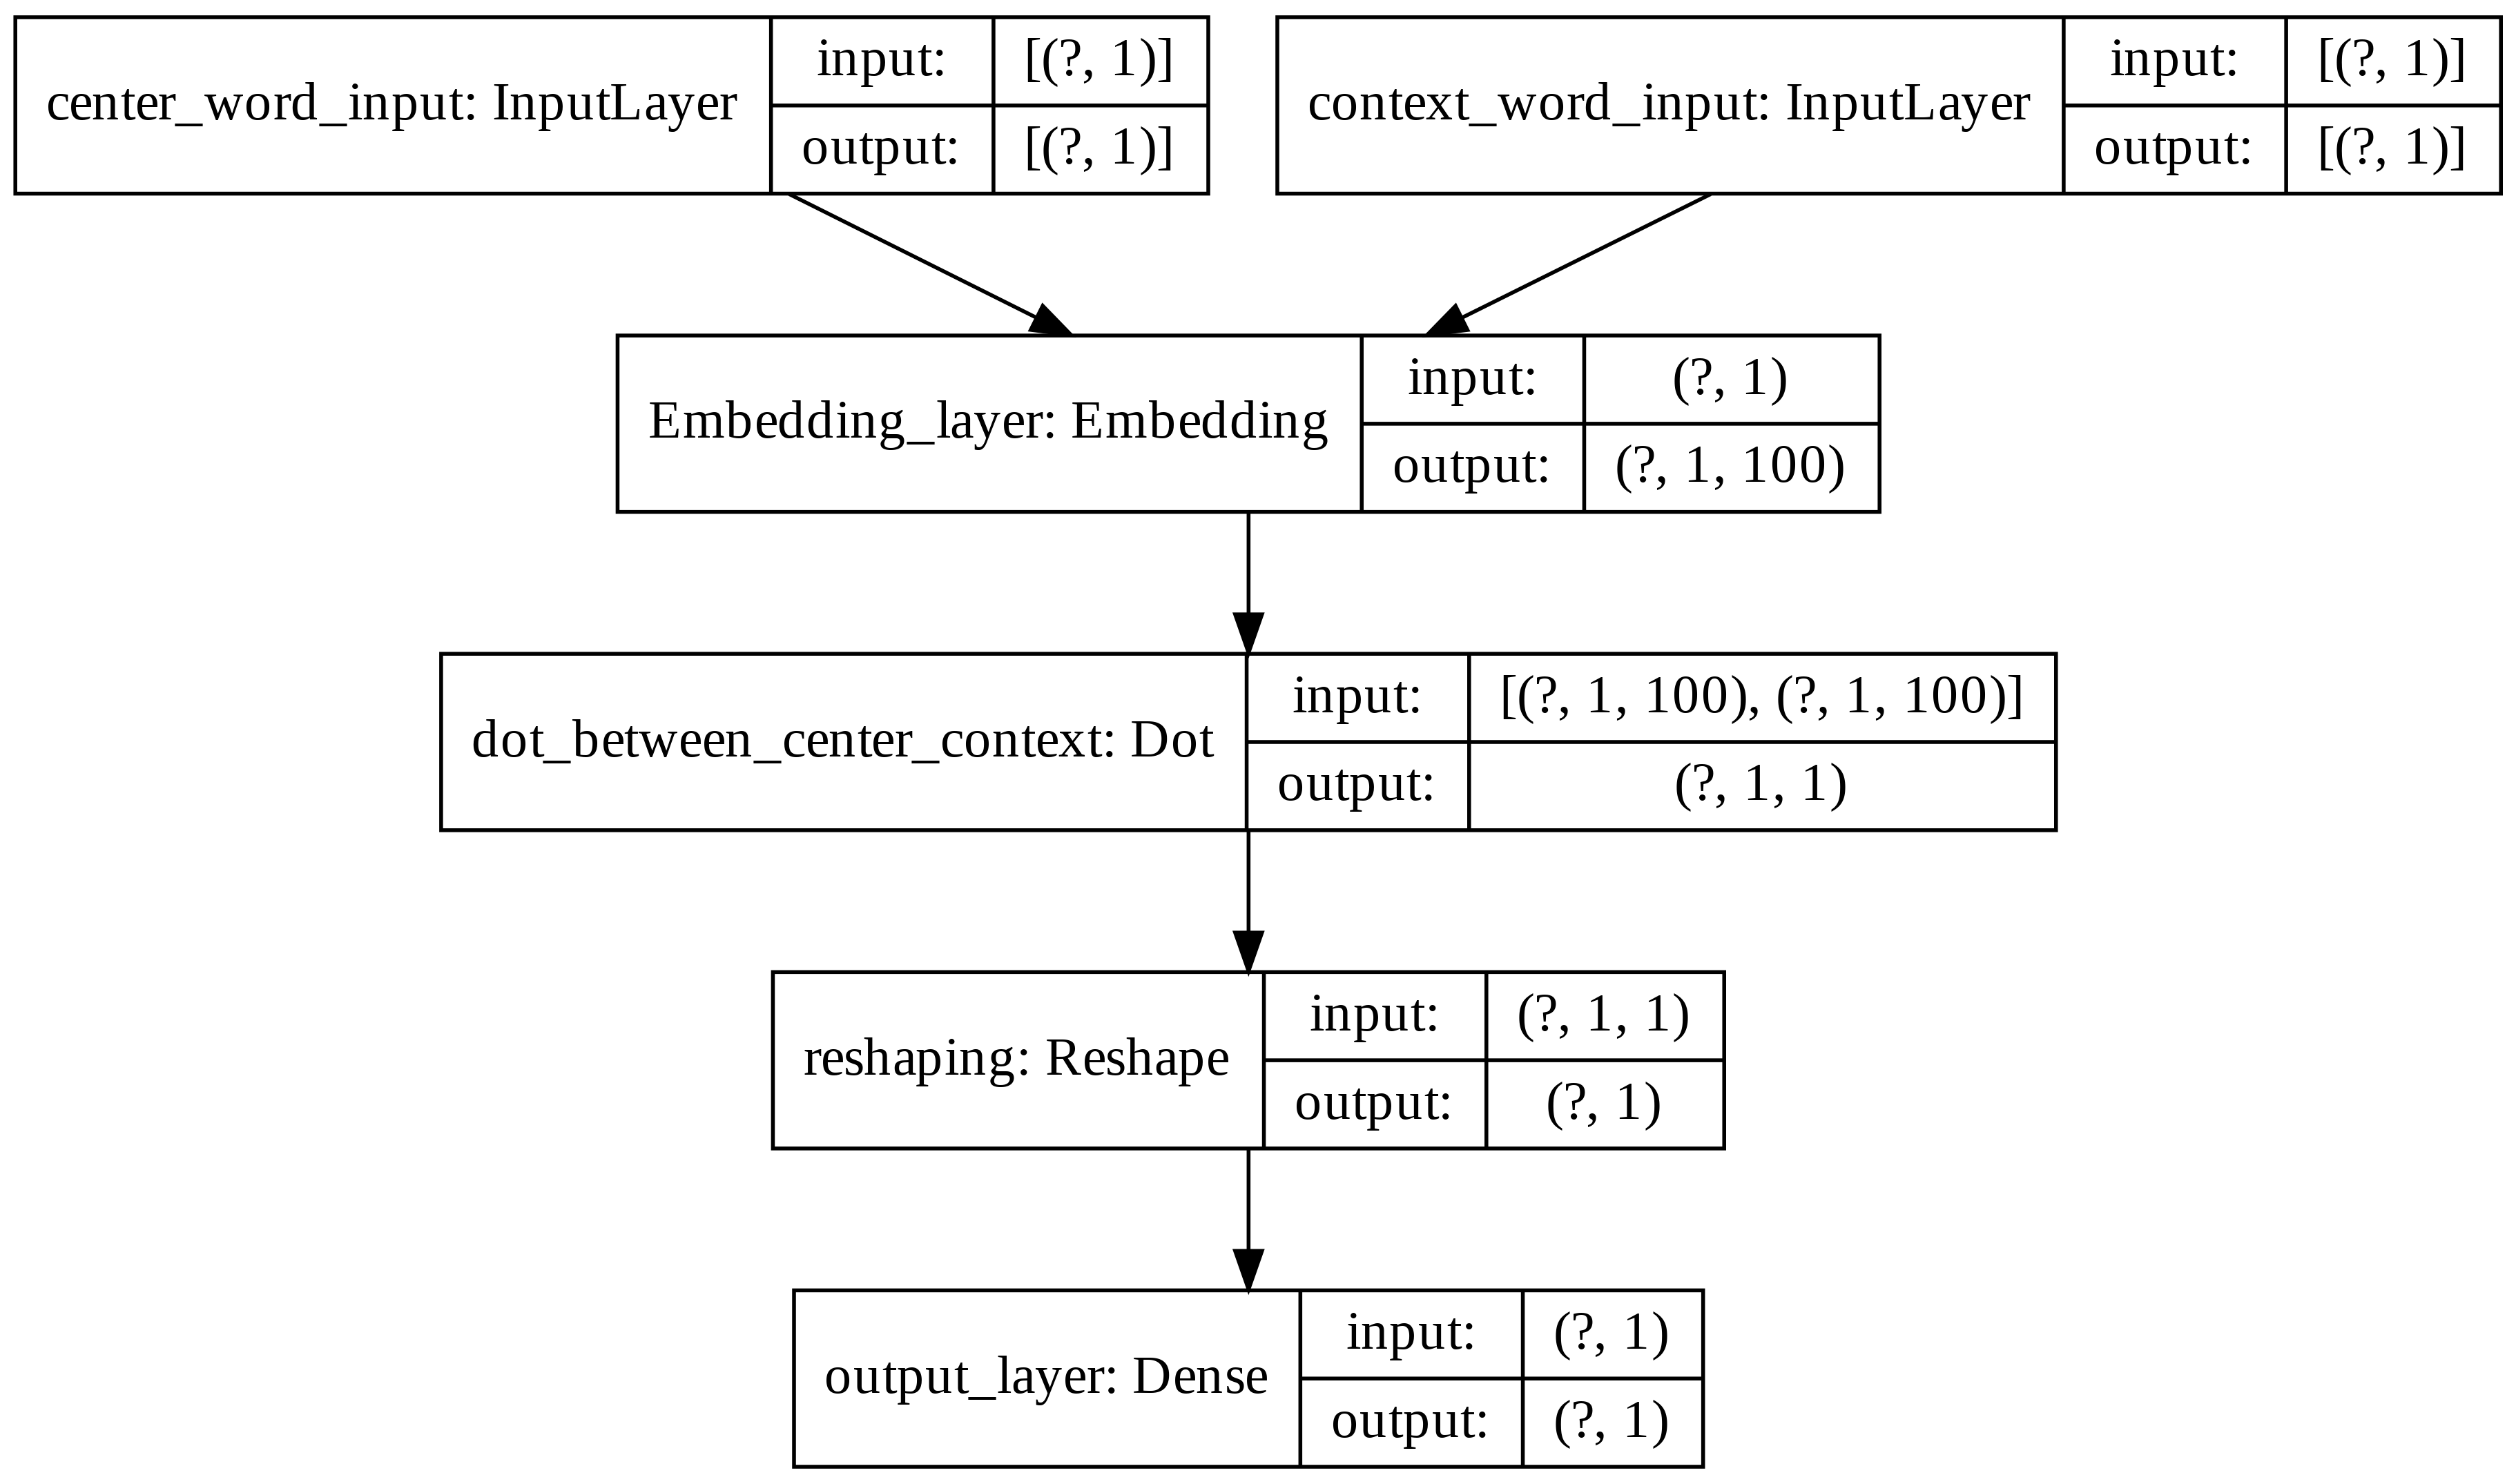

In [17]:
tf.keras.utils.plot_model(sgns_w2v, to_file="/content/drive/My Drive/word2vec/sgna_w2v.png", show_shapes=True, dpi=400)

In [0]:
##Skipgram with Negativive sampling generator 
##for generating the skip gram negative samples we can use tf.keras.preprocessing.sequence.skipgrams and 
#internally uses sampling table so we need to generate sampling table with tf.keras.preprocessing.sequence.make_sampling_table
sampling_table_ns = tf.keras.preprocessing.sequence.make_sampling_table(size=len(tokenizer.word_index)+1,   
                                                                        sampling_factor=1e-05)
def generate_sgns():
    for seq in seq_texts:
        generated_samples, labels = tf.keras.preprocessing.sequence.skipgrams(sequence=seq, 
                                                                      vocabulary_size=len(tokenizer.word_index)+1, 
                                                                      window_size=3, negative_samples=10, 
                                                                      sampling_table=sampling_table_ns)
        length_samples = len(generated_samples)
        for i in range(length_samples):
            yield [generated_samples[i][0]], [generated_samples[i][1]], [labels[i]]

In [0]:
##creating the tf dataset
tfdataset_gen = tf.data.Dataset.from_generator(generate_sgns, output_types=(tf.int64, tf.int64, tf.int64))
tfdataset_gen = tfdataset_gen.repeat().batch(2048).prefetch(tf.data.experimental.AUTOTUNE)

In [19]:
##training

##optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

##train step function to train
@tf.function
def train_step(input_center, input_context, output_vector, loss_fn):
    with tf.GradientTape() as tape:
        #forward propagation
        output_predicted = sgns_w2v(inputs=[input_center, input_context], training=True)
        #loss
        loss = loss_fn(output_vector, output_predicted)
    #getting gradients
    gradients = tape.gradient(loss, sgns_w2v.trainable_variables)
    #applying gradients
    optimizer.apply_gradients(zip(gradients, sgns_w2v.trainable_variables))
    return loss, gradients

##number of epochs
no_iterations=100000

##metrics # Even if you use .fit method, it alsocalculates batchwise loss/metric and aggregates those.  
train_loss = tf.keras.metrics.Mean(name='train_loss')

#tensorboard file writers
wtrain = tf.summary.create_file_writer(logdir='/content/drive/My Drive/word2vec_logs/logs/w2vns/train')

##creating a loss object for this classification problem
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=False, 
                                                                reduction='auto')

##check point to save
checkpoint_path = "/content/drive/My Drive/word2vec_logs/checkpoints/w2vNS/train"
ckpt = tf.train.Checkpoint(optimizer=optimizer, model=sgns_w2v)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

counter = 0
#training anf validating
for in_center, in_context, out_label in tfdataset_gen:
    #train step
    loss_, gradients = train_step(in_center, in_context, out_label, loss_function)
    #adding loss to train loss
    train_loss(loss_)

    counter = counter + 1
          
    ##tensorboard 
    with tf.name_scope('per_step_training'):
        with wtrain.as_default():
            tf.summary.scalar("batch_loss", loss_, step=counter)
    with tf.name_scope("per_batch_gradients"):
        with wtrain.as_default():
            for i in range(len(sgns_w2v.trainable_variables)):
                name_temp = sgns_w2v.trainable_variables[i].name
                tf.summary.histogram(name_temp, gradients[i], step=counter)
    
    if counter%100 == 0:
        #printing
        template = '''Done {} iterations, Loss: {:0.6f}'''
    
        print(template.format(counter, train_loss.result()))

        if counter%200 == 0:
            ckpt_save_path  = ckpt_manager.save()
            print ('Saving checkpoint for iteration {} at {}'.format(counter+1, ckpt_save_path))
        
        train_loss.reset_states()
    if counter > no_iterations:
        break

Done 100 iterations, Loss: 0.604547
Done 200 iterations, Loss: 0.474490
Saving checkpoint for iteration 201 at /content/drive/My Drive/word2vec/checkpoints/w2vNS/train/ckpt-1
Done 300 iterations, Loss: 0.396538
Done 400 iterations, Loss: 0.349565
Saving checkpoint for iteration 401 at /content/drive/My Drive/word2vec/checkpoints/w2vNS/train/ckpt-2
Done 500 iterations, Loss: 0.318413
Done 600 iterations, Loss: 0.294752
Saving checkpoint for iteration 601 at /content/drive/My Drive/word2vec/checkpoints/w2vNS/train/ckpt-3
Done 700 iterations, Loss: 0.284080
Done 800 iterations, Loss: 0.270796
Saving checkpoint for iteration 801 at /content/drive/My Drive/word2vec/checkpoints/w2vNS/train/ckpt-4
Done 900 iterations, Loss: 0.270553
Done 1000 iterations, Loss: 0.265735
Saving checkpoint for iteration 1001 at /content/drive/My Drive/word2vec/checkpoints/w2vNS/train/ckpt-5
Done 1100 iterations, Loss: 0.254815
Done 1200 iterations, Loss: 0.256477
Saving checkpoint for iteration 1201 at /content/

KeyboardInterrupt: ignored

In [20]:
##you can load from below checkpoints
ckpt_manager.checkpoints

['/content/drive/My Drive/word2vec/checkpoints/w2vNS/train/ckpt-48',
 '/content/drive/My Drive/word2vec/checkpoints/w2vNS/train/ckpt-49',
 '/content/drive/My Drive/word2vec/checkpoints/w2vNS/train/ckpt-50']

In [0]:
#3getting the word vectors
word_vectors = sgns_w2v.get_weights()[0]
##convering into dict
word_vectors_dict = {}
for word, number in tokenizer.word_index.items():
    word_vectors_dict[word] = word_vectors[number]

In [23]:
##word vector for movies
word_vectors_dict['movies']

array([-0.2221755 , -0.18669862,  0.3863997 ,  0.16353783,  0.48968604,
        0.2833837 ,  0.26337534, -0.26018345, -0.33032453, -0.00745563,
        0.22735667, -0.19500558, -0.2328427 ,  0.5882469 ,  0.09525809,
        0.01237087, -0.625632  , -0.50378   ,  0.10754599,  0.2493134 ,
        0.40277463, -0.04267837,  0.18733528,  0.27185774, -0.25151426,
        0.5165392 ,  0.58549434, -0.18639866, -0.20587556,  0.06770392,
       -0.6673686 ,  0.3986967 , -0.4840714 , -0.18505292,  0.47891718,
        0.24514674,  0.09929848, -0.25571132,  0.3336661 ,  0.32497853,
        0.24337682,  0.15052995, -0.12742113,  0.24181102, -0.37475356,
        0.11621896, -0.1309716 , -0.09257291, -0.21943405,  0.16859975,
       -0.05694135,  0.5531232 , -0.06470597, -0.30475754,  0.78656405,
        0.3459184 ,  0.38787752, -0.04961852, -0.40532354, -0.2574787 ,
       -0.5648121 , -0.4802717 ,  0.34445754, -0.5438863 , -0.00381275,
       -0.44894516, -0.10664288, -0.19676094,  0.34198862, -0.04

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
##https://stackoverflow.com/a/54809609/10899915
def save_word2vec_format_dict(fname, vocab, vectors, binary=True, total_vec=None):
  """Store the input-hidden weight matrix in the same format used by the original
    C word2vec-tool, for compatibility.

    Parameters
    ----------
    fname : str
        The file path used to save the vectors in.
    vocab : dict
        The vocabulary of words.
    vectors : numpy.array
        The vectors to be stored.
    binary : bool, optional
        If True, the data wil be saved in binary word2vec format, else it will be saved in plain text.
    total_vec : int, optional
        Explicitly specify total number of vectors
        (in case word vectors are appended with document vectors afterwards).
    """
  if not (vocab or vectors):
      raise RuntimeError("no input")
  if total_vec is None:
      total_vec = len(vocab)
  vector_size = vectors.shape[1]
  assert (len(vocab), vector_size) == vectors.shape
  with utils.smart_open(fname, 'wb') as fout:
      print(total_vec, vector_size)
      fout.write(utils.to_utf8("%s %s\n" % (total_vec, vector_size)))
      # store in sorted order: most frequent words at the top
      for word, row in vocab.items():
          if binary:
              row = row.astype(REAL)
              fout.write(utils.to_utf8(word) + b" " + row.tostring())
          else:
              fout.write(utils.to_utf8("%s %s\n" % (word, ' '.join(repr(val) for val in row))))

In [36]:
##saving the file
from numpy import zeros, dtype, float32 as REAL, ascontiguousarray, fromstring
from gensim import utils

model_gensim = gensim.models.keyedvectors.Word2VecKeyedVectors(vector_size=50)
model_gensim.vocab = word_vectors_dict
model_gensim.vectors = np.array(list(word_vectors_dict.values()))
save_word2vec_format_dict(binary=True, fname='w2vns.bin', total_vec=len(word_vectors_dict), vocab=model_gensim.vocab, vectors=model_gensim.vectors)

206705 100


In [0]:
##loading model
model_gensim = gensim.models.keyedvectors.Word2VecKeyedVectors.load_word2vec_format('w2vns.bin', binary=True)

In [38]:
##word vectors
model_gensim.wv['movies']

array([-0.2221755 , -0.18669862,  0.3863997 ,  0.16353783,  0.48968604,
        0.2833837 ,  0.26337534, -0.26018345, -0.33032453, -0.00745563,
        0.22735667, -0.19500558, -0.2328427 ,  0.5882469 ,  0.09525809,
        0.01237087, -0.625632  , -0.50378   ,  0.10754599,  0.2493134 ,
        0.40277463, -0.04267837,  0.18733528,  0.27185774, -0.25151426,
        0.5165392 ,  0.58549434, -0.18639866, -0.20587556,  0.06770392,
       -0.6673686 ,  0.3986967 , -0.4840714 , -0.18505292,  0.47891718,
        0.24514674,  0.09929848, -0.25571132,  0.3336661 ,  0.32497853,
        0.24337682,  0.15052995, -0.12742113,  0.24181102, -0.37475356,
        0.11621896, -0.1309716 , -0.09257291, -0.21943405,  0.16859975,
       -0.05694135,  0.5531232 , -0.06470597, -0.30475754,  0.78656405,
        0.3459184 ,  0.38787752, -0.04961852, -0.40532354, -0.2574787 ,
       -0.5648121 , -0.4802717 ,  0.34445754, -0.5438863 , -0.00381275,
       -0.44894516, -0.10664288, -0.19676094,  0.34198862, -0.04

In [39]:
model_gensim.wv.most_similar(positive='movie')

[('film', 0.8326629996299744),
 ('macafee', 0.746140718460083),
 ('.confronting', 0.7361078262329102),
 ('-darth', 0.7354727983474731),
 ('time-setting', 0.7345552444458008),
 ('turtorro', 0.73114013671875),
 ('savoys', 0.7304239869117737),
 ("'nuff", 0.7302582263946533),
 ('archdeacon', 0.7295699119567871),
 ('ethiopia', 0.728302538394928)]